In [37]:
import math
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools

print("Libraries Imported")

Libraries Imported


In [38]:
data = pd.read_csv('/kaggle/input/cicddos-dataset/cicddos2019_dataset.csv')

# rows = data.sample(n=int(0.25 * len(data)))

# sample_size = math.ceil(0.25 * len(data))
# rows = data.sample(n=sample_size)

# if sample_size == len(rows):
#     print(len(data), len(rows))
#     data = rows
# else:
#     print("###")

# ===============================
# Increased dataset usage to reduce overfitting
# ===============================
SAMPLE_RATIO = 0.25   # 25% of dataset (reviewer-defensible)

sample_size = int(SAMPLE_RATIO * len(data))
data = data.sample(n=sample_size, random_state=42)

print(f"Using {SAMPLE_RATIO*100}% of dataset: {len(data)} samples")


Using 25.0% of dataset: 107842 samples


In [39]:
def plotPerColumnDistribution(data, nGraphShown, nGraphPerRow):
    nunique = data.nunique()
    data = data[[col for col in data if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = data.shape
    columnNames = list(data)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columndata = data.iloc[:, i]
        if not np.issubdtype(type(columndata.iloc[0]), np.number):
            valueCounts = columndata.value_counts()
            valueCounts.plot.bar()
        else:
            columndata.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

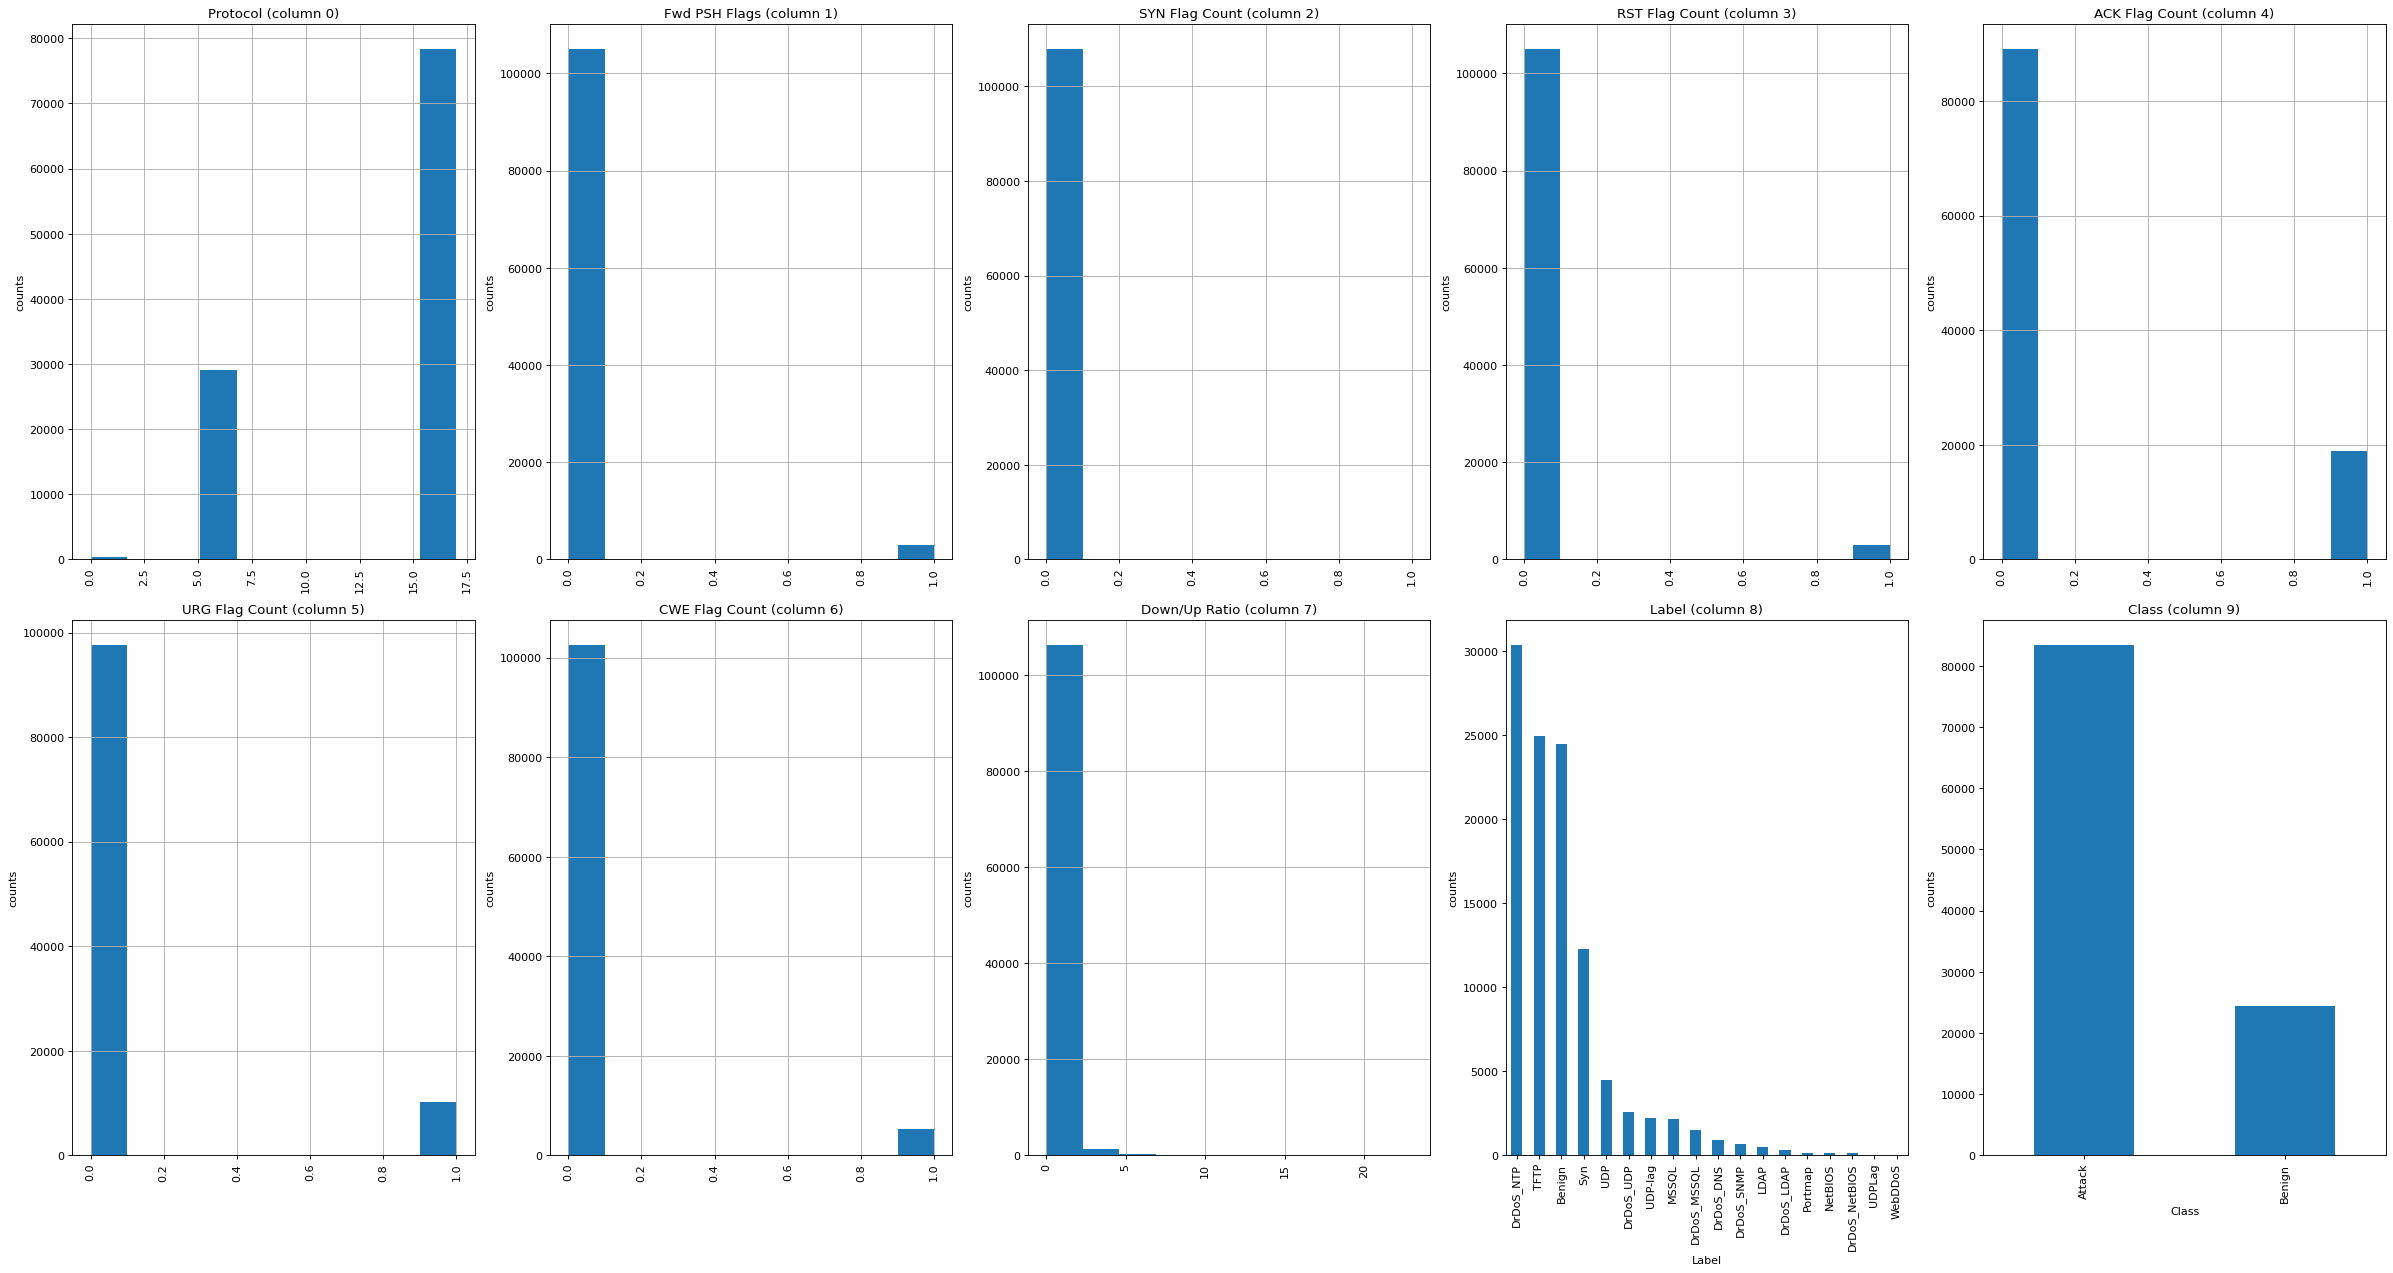

In [40]:
plotPerColumnDistribution(data, 100, 5)

In [41]:
#Split dataset on train and test
# ===============================
# Stratified Train-Test Split (handles imbalance correctly)
# ===============================
train, test = train_test_split(
    data,
    test_size=0.3,
    random_state=10,
    stratify=data['Label']
)


train.describe()
test.describe()

# Packet Attack Distribution
train['Label'].value_counts()
test['Label'].value_counts()

Label
DrDoS_NTP        9107
TFTP             7478
Benign           7339
Syn              3687
UDP              1344
DrDoS_UDP         778
UDP-lag           657
MSSQL             644
DrDoS_MSSQL       455
DrDoS_DNS         276
DrDoS_SNMP        208
LDAP              142
DrDoS_LDAP         99
Portmap            47
DrDoS_NetBIOS      41
NetBIOS            41
WebDDoS             5
UDPLag              5
Name: count, dtype: int64

In [42]:
# ===============================
# Scaling with column preservation
# ===============================
cols = train.select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()

sc_train = scaler.fit_transform(train[cols])
sc_test  = scaler.transform(test[cols])

# Convert back to DataFrame WITH column names
sc_traindf = pd.DataFrame(sc_train, columns=cols, index=train.index)
sc_testdf  = pd.DataFrame(sc_test,  columns=cols, index=test.index)

# # extract numerical attributes and scale it to have zero mean and unit variance  
# cols = train.select_dtypes(include=['float64','int64']).columns
# sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
# sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# # turn the result back to a dataframe
# sc_traindf = pd.DataFrame(sc_train, columns = cols)
# sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [43]:
onehotencoder = OneHotEncoder() 

trainDep = train['Label'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test['Label'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [44]:
train_X=sc_traindf
train_y=trainDep[:,0]

test_X=sc_testdf
test_y=testDep[:,0]

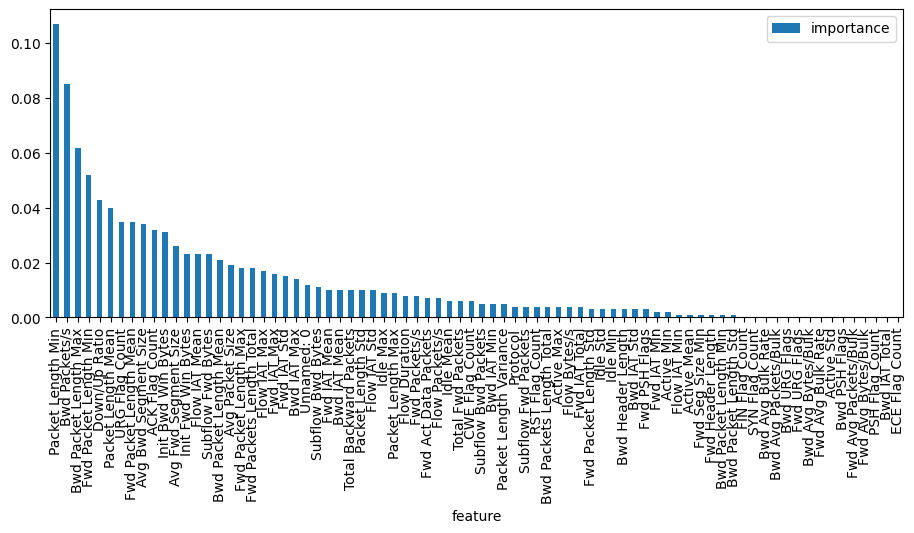

In [45]:
# ===============================
# Feature Selection using Random Forest
# ===============================
train_X = sc_traindf
test_X  = sc_testdf

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(train_X, train_y)

# Feature importance
score = np.round(rfc.feature_importances_, 3)

importances = pd.DataFrame({
    'feature': train_X.columns,
    'importance': score
}).sort_values('importance', ascending=False).set_index('feature')

# Plot feature importance
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar()
plt.show()


In [46]:
# create the RFE model and select 20 attributes
rfe = RFE(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    n_features_to_select=20
)

rfe.fit(train_X, train_y)

selected_features = train_X.columns[rfe.support_]

train_X = train_X[selected_features]
test_X  = test_X[selected_features]

print("Selected Features:", list(selected_features))
print("X_train shape:", train_X.shape)
print("X_test shape:", test_X.shape)


Selected Features: ['Unnamed: 0', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Mean', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Variance', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes']
X_train shape: (75489, 20)
X_test shape: (32353, 20)


In [47]:
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn.naive_bayes import BernoulliNB 
    from sklearn import tree
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    
    RF_Classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    
    SVM_Classifier = SVC(
        kernel='rbf',
        probability=True,
        random_state=42
    )
    
    
    # Assuming train_X and train_y are your feature and target variables
    
    # # Dataset Partition
    # X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_y, train_size=0.70, random_state=2)
    
    # ===============================
    # Final training and test sets
    # ===============================
    X_train = train_X
    Y_train = train_y
    
    X_test  = test_X
    Y_test  = test_y
    
    # Fitting Models
    # Train KNeighborsClassifier Model
    KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
    KNN_Classifier.fit(X_train, Y_train)
    
    # Train LogisticRegression Model
    LGR_Classifier = LogisticRegression(
    solver='lbfgs',
    max_iter=2000,
    class_weight='balanced',   # handles imbalance defensively
    random_state=42
    )
    LGR_Classifier.fit(X_train, Y_train)

    
    # Train Gaussian Naive Baye Model
    BNB_Classifier = BernoulliNB()
    BNB_Classifier.fit(X_train, Y_train)
    
    # Train Decision Tree Model
    DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
    DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [48]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_probabilistic_model(model, X, y):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:,1]
        roc_auc = roc_auc_score(y, y_prob)
        pr_auc  = average_precision_score(y, y_prob)
        return roc_auc, pr_auc
    else:
        return None, None

In [49]:
# ===============================
# Model Evaluation (CV + Train Metrics)
# ===============================
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

for name, model in models:
    
    print()
    print('============================== {} Model Evaluation =============================='.format(name))
    print()

    # ---- 1. Cross-validation (uses CLONED models) ----
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        model,
        X_train,
        Y_train,
        cv=skf,
        scoring='f1_macro'
    )

    print("Cross-Validation F1-Macro (Mean ± Std):")
    print(f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print()

    # ---- 2. Fit model ONCE on full training set ----
    model.fit(X_train, Y_train)

    # ---- 3. Training-set evaluation ----
    y_train_pred = model.predict(X_train)

    print("Training Accuracy:")
    print(metrics.accuracy_score(Y_train, y_train_pred))
    print()

    print("Confusion Matrix (Train):")
    print(metrics.confusion_matrix(Y_train, y_train_pred))
    print()

    print("Classification Report (Train):")
    print(metrics.classification_report(Y_train, y_train_pred))
    print()

    # ---- 4. ROC-AUC & PR-AUC (if probabilistic) ----
    roc_auc, pr_auc = evaluate_probabilistic_model(model, X_train, Y_train)
    if roc_auc is not None:
        print("ROC-AUC:", round(roc_auc, 4))
        print("PR-AUC:", round(pr_auc, 4))
        print()



============================== Naive Baye Classifier Model Evaluation ==============================

Cross-Validation F1-Macro (Mean ± Std):
0.8305 ± 0.0032

Training Accuracy:
0.8587078912159387

Confusion Matrix (Train):
[[47806 10558]
 [  108 17017]]

Classification Report (Train):
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90     58364
         1.0       0.62      0.99      0.76     17125

    accuracy                           0.86     75489
   macro avg       0.81      0.91      0.83     75489
weighted avg       0.91      0.86      0.87     75489


ROC-AUC: 0.9904
PR-AUC: 0.9693


============================== Decision Tree Classifier Model Evaluation ==============================

Cross-Validation F1-Macro (Mean ± Std):
0.9986 ± 0.0006

Training Accuracy:
1.0

Confusion Matrix (Train):
[[58364     0]
 [    0 17125]]

Classification Report (Train):
              precision    recall  f1-score   support

         0.0       1.

In [50]:
#Validate Models
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.8583748029549038

Confusion matrix:
 [[20480  4534]
 [   48  7291]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.82      0.90     25014
         1.0       0.62      0.99      0.76      7339

    accuracy                           0.86     32353
   macro avg       0.81      0.91      0.83     32353
weighted avg       0.91      0.86      0.87     32353



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9991345470280963

Confusion matrix:
 [[24996    18]
 [   10  7329]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     25014
         1.0       1.00      1.00      1.00      7339

    accuracy                           1.00     32353
   macro avg     

In [51]:
# PREDICTING FOR TEST DATA
pred_knn = KNN_Classifier.predict(test_X)
pred_NB = BNB_Classifier.predict(test_X)
pred_log = LGR_Classifier.predict(test_X)
pred_dt = DTC_Classifier.predict(test_X)

print("KNN: ", pred_knn)
print("BNB: ", pred_NB)
print("LGR: ", pred_log)
print("DTC: ", pred_dt)

KNN:  [0. 0. 0. ... 0. 0. 1.]
BNB:  [0. 0. 0. ... 0. 0. 1.]
LGR:  [0. 0. 0. ... 0. 0. 1.]
DTC:  [0. 0. 0. ... 0. 0. 1.]
